# Grover's algorithm 

*Authors*: Júlia Barberà, 23 february 2022

This notebook presents a demonstration of how Grover's algorithm performs when we want to find an element from a list. It also shows how the results converge as $\sqrt(N)$ with $N = 2^{nqubits}$.
 <br>
 
We use an arbitrary number of qubits, in our case 4, to show the results but it could be done with a different value of $nqubits$. 

The code is written using Qibo language and qibojit, qibotf, tensorflow, numpy simulator as a default backend.

__Table of contents:__
1. Defining functions
    1. Binary to decimal function
    1. MCZ gate 
    1. Grover's Oracle 
    1. Diffusion operator 


2. Main code: Grover's algorithm
    1. Grover's algorithm for 5 qubits
    1. Plots

In [2]:
# Import all libraries that I will use
import numpy as np
from qibo.models import Circuit
from qibo import gates
from qibo import callbacks
import matplotlib.pyplot as plt
import time 

## Functions


Firstly, we introduce some functions that we will use in the main code. They will be universal for any state we want to find. 

### Binary to decimal function

There are two methods to convert a binary number into a decimal number and we will be using one of them: using the positional notation. The weight of the positions will be $2^0, 2^1, 2^2, 2^3,...$ so the first thing we need to do is count the number of digits (positions) the binary number has. Then, these weigths will be multiplying the digit corresponding to its binary number (0 or 1). Finallly, we will sum everything. Let's assume our binray number is $10110$:


<br>

<center> decimal number $= 1 \cdot 2^4 + 0 \cdot 2^3 + 1 \cdot 2^2 + 1 \cdot 2^1 + 0 \cdot 2^0 = 22 $ </center>


<br>

The binary state will be the one we want to find and we will use this function to convert the state in order to find the inverting matrix. 

In [3]:
def binary_to_decimal(binary_number):
    decimal_number = 0 #Initialize the number 

    for position, string_digit in enumerate(binary_number[::-1]):
        decimal_number += int(string_digit) * 2 ** position

    return decimal_number


### Multi-controlled Z gate 

The CZ gate is used to invert the phase of the state $|11...1\rangle$. To make it easier we can express the CZ gate in terms of other quantum gates: $Z = H X H$. 
So the MCZ of the circuit will have the following transformation: 

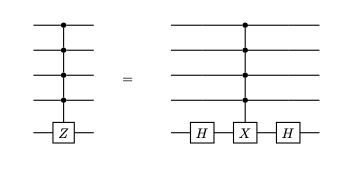

We will use this gate for the Oracle and the Difussion operator. 

In [4]:
def MCZ(q0,nqubits): # defining multi-controlled Z function 
    c.add(gates.H(q0))
    c.add(gates.X(q0).controlled_by(*range(1,nqubits)))
    c.add(gates.H(q0))
    return c 

### Grover's oracle: $U_w$

The Grover's oracle generates a reflection to the state we want to find. Imagine we have the following superposition ($nqubits = 2$): $|s\rangle = \frac{1}{\sqrt{2}} (|00 \rangle +|01 \rangle +|10 \rangle +|11 \rangle) $ and we want to find the state $|10 \rangle$. When we apply the oracle to the initial state it will turn into: <center> $U_w|s\rangle = \frac{1}{\sqrt{2}} (|00 \rangle +|01 \rangle -|10 \rangle +|11 \rangle) $ 
    
We can recognize that the CZ quantum gate is the one that performs this operation. But firstly, we will create a classical diagonal matrix filled with ones on the diagonal except the position that corresponds to the state we want to find which will have the value -1 in order to flip the state.  

In [5]:
def oracle_general(nqubits,state):
    
    inv_matrix = np.zeros( (2**nqubits, 2**nqubits) ) 

    for i in range(0,2**nqubits):
        for j in range(0,2**nqubits):
            if i == j:
                if i == state : 
                    inv_matrix[i][j] = -1 #add a -1 in order to flip the state
                else:
                    inv_matrix[i][j] = 1 

    return c.add(gates.Unitary(inv_matrix,*range(0,nqubits)))
    

### Grover's diffusion operator: $U_s$

This operator, expressed like: $U_s = 2|s\rangle \langle s | - I$,  will be applied after the Oracle, and will perform an extra reflection to the state $U_w |s\rangle$. It will aplificate the state we want to find making it have a much greater probability than the other ones. The Difussion operator will have the following form: 

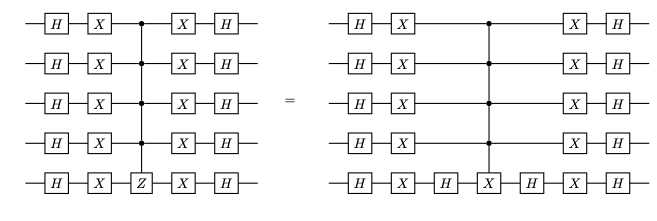

The hadamard gates will create a superposition of all states. Then, the X gate performs a qubit-flip (it is the equivalent to the NOT classical gate) so it makes a rotation by π radians around the x-axis of the Bloch sphere. When we have the states fliped...

In [26]:
def difussion(q0,nqubits): 

    c.add([gates.H(i) for i in range(nqubits)])
        
    c.add([gates.X(i) for i in range(nqubits)])
        
    MCZ(q0,nqubits) #q0 is the target and the other ones control qubits
    
    c.add([gates.X(i) for i in range(nqubits)])
    
    c.add([gates.H(i) for i in range(nqubits)])
    
    return c

## Main code: Grover's algorithm 

### Grover's algorithm for 5 qubits

In [27]:
nqubits = int(input("How many qubits does the circuit have? "))
state = int(input("Which state do you want to find? "))

print()
print()

c = Circuit(nqubits) # Construct the circuit (2 qubits)

start_time = time.time()

c.add([gates.H(i) for i in range(nqubits)])

R = int((np.pi/4)*np.sqrt(2**nqubits))
print("Number of times we apply the oracle:", R)
print()

for i in range(0,R):
    # Rotation of the state we are searching for 
    oracle_general(nqubits,state) 

    difussion(0,nqubits)
    

# Execute the circuit and obtain the final state
result = c() 

print("It took %s seconds to find the state" % (time.time()-start_time))
print()
# Draw the circuit
print(c.draw())

How many qubits does the circuit have? 4
Which state do you want to find? 10


Number of times we apply the oracle: 3

It took 0.021987199783325195 seconds to find the state

q0: ─H─U─H─X─H─X─H─X─H─U─H─X─H─X─H─X─H─U─H─X─H─X─H─X─H─
q1: ─H─U─H─X───o─X─H───U─H─X───o─X─H───U─H─X───o─X─H───
q2: ─H─U─H─X───o─X─H───U─H─X───o─X─H───U─H─X───o─X─H───
q3: ─H─U─H─X───o─X─H───U─H─X───o─X─H───U─H─X───o─X─H───


### Plots

The plot will show, from all states available (created by nqubits), the one with more probability which corresponds to the one we were searching for.

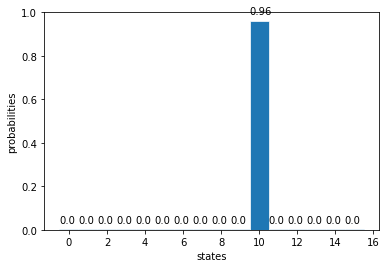

In [28]:
x = range(2**nqubits) 
y = result.state(numpy=True)

prob = [x*x.conjugate() for x in y] # elevating coeficients = probability 

fig, ax = plt.subplots()

ax.bar(x, prob, width=1, edgecolor="white", linewidth=0.7)
ax.set(ylim=(0, 1), xlabel = 'states', ylabel = 'probabilities')

i=0 #writes the probability of each state 
for el in prob:
    ax.text(i-0.5,el+0.03, str(round(el.real, 2)), fontsize=10)
    i=i+1

plt.show()

### Comaprison with classical method

In [33]:
lista = np.arange(2**nqubits)

np.random.shuffle(lista)

start_time = time.time()

for el in lista:
    if el == state:
        print("S'ha trobat l'estat", state, "en %s seconds" % (time.time()-start_time))

S'ha trobat l'estat 10 en 0.00012111663818359375 seconds
